In [29]:
# Using segmentation_models for image segmentation task, https://github.com/qubvel/segmentation_models
! pip install segmentation-models

In [57]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib.pyplot as plt
%matplotlib inline
from time import time
from datetime import datetime

import pandas as pd
import numpy as np
import os
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend
import tensorflow.keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Conv2D, BatchNormalization, Dropout
from tensorflow.keras.models import Model, load_model
import tensorflow as tf
from tensorflow.python.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import recall_score
from random import random
from random import seed

# https://github.com/qubvel/segmentation_models
import segmentation_models
print(segmentation_models.__version__)

import segmentation_models as sm
from segmentation_models import Unet
from segmentation_models import get_preprocessing

from tensorflow.keras.utils import plot_model

1.0.1


In [2]:
df = pd.read_csv('C:/Users/sonali/Desktop/DS/Semester_4/DLproject/severstal-steel-defect-detection/train.csv')
df.shape

(7095, 3)

In [3]:
df.head()

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


Data Preparation:
Available data is not in the X_train, Y_train format, we need to generate these with the help of getting image names from train_images folder and merging these with train.csv 

In [4]:
from glob import glob
# set paths to train and test image datasets
TRAIN_PATH = 'C:/Users/sonali/Desktop/DS/Semester_4/DLproject/severstal-steel-defect-detection/train_images/'
TEST_PATH = 'C:/Users/sonali/Desktop/DS/Semester_4/DLproject/severstal-steel-defect-detection/test_images/'

# load dataframe with train labels
train_fns = sorted(glob(TRAIN_PATH + '*.jpg'))
test_fns = sorted(glob(TEST_PATH + '*.jpg'))

print('There are {} images in the train set.'.format(len(train_fns)))
print('There are {} images in the test set.'.format(len(test_fns)))

There are 12568 images in the train set.
There are 5506 images in the test set.


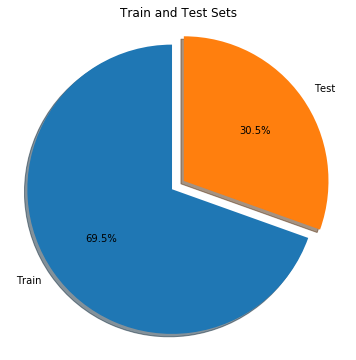

In [48]:
# plotting a pie chart which demonstrates train and test sets
labels = 'Train', 'Test'
sizes = [len(train_fns), len(test_fns)]
explode = (0, 0.1)

fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax.axis('equal')
ax.set_title('Train and Test Sets')

plt.show()

In [16]:
train_image_names = os.listdir(TRAIN_PATH)
test_image_names = os.listdir(TEST_PATH)

train_image_names[:5]

['0002cc93b.jpg',
 '00031f466.jpg',
 '000418bfc.jpg',
 '000789191.jpg',
 '0007a71bf.jpg']

In [17]:
tr_img_id = []
tr_cls_id = []
for i in os.listdir(TRAIN_PATH):
    tr_img_id.append(i)
    tr_cls_id.append(1)
    tr_img_id.append(i)
    tr_cls_id.append(2)
    tr_img_id.append(i)
    tr_cls_id.append(3)
    tr_img_id.append(i)
    tr_cls_id.append(4)
train_img_nms = pd.DataFrame(tr_img_id,columns=['ImageId'])
train_img_nms['ClassId'] = tr_cls_id
train_img_nms.head()

,ImageId,ClassId
0,0002cc93b.jpg,1
1,0002cc93b.jpg,2
2,0002cc93b.jpg,3
3,0002cc93b.jpg,4
4,00031f466.jpg,1


In [19]:
train_df = pd.merge(train_img_nms, df,how='outer',on=['ImageId','ClassId'])
train_df = train_df.fillna('')
train_df.head()

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0002cc93b.jpg,2,
2,0002cc93b.jpg,3,
3,0002cc93b.jpg,4,
4,00031f466.jpg,1,


In [20]:
train_data = pd.pivot_table(train_df, values='EncodedPixels', index='ImageId',columns='ClassId', aggfunc=np.sum).astype(str)
train_data = train_data.reset_index()
train_data.columns = ['ImageId','Defect_1','Defect_2','Defect_3','Defect_4']
train_data.head()

,ImageId,Defect_1,Defect_2,Defect_3,Defect_4
0,0002cc93b.jpg,29102 12 29346 24 29602 24 29858 24 30114 24 3...,,,
1,00031f466.jpg,,,,
2,000418bfc.jpg,,,,
3,000789191.jpg,,,,
4,0007a71bf.jpg,,,18661 28 18863 82 19091 110 19347 110 19603 11...,


In [21]:
tmp = []
for i in range(len(train_data)):
    if all((train_data['Defect_1'][i]=='',train_data['Defect_2'][i]=='',train_data['Defect_3'][i]=='',train_data['Defect_4'][i]=='')):
        tmp.append(0)
    else:
        tmp.append(1)
train_data['hasDefect'] = tmp

tmp = []
for i in range(len(train_data)):
    if train_data['Defect_1'][i]=='':
        tmp.append(0)
    else:
        tmp.append(1)
train_data['hasDefect_1'] = tmp

tmp = []
for i in range(len(train_data)):
    if train_data['Defect_2'][i]=='':
        tmp.append(0)
    else:
        tmp.append(1)
train_data['hasDefect_2'] = tmp

tmp = []
for i in range(len(train_data)):
    if train_data['Defect_3'][i]=='':
        tmp.append(0)
    else:
        tmp.append(1)
train_data['hasDefect_3'] = tmp

tmp = []
for i in range(len(train_data)):
    if train_data['Defect_4'][i]=='':
        tmp.append(0)
    else:
        tmp.append(1)
train_data['hasDefect_4'] = tmp

train_data.head()

,ImageId,Defect_1,Defect_2,Defect_3,Defect_4,hasDefect,hasDefect_1,hasDefect_2,hasDefect_3,hasDefect_4
0,0002cc93b.jpg,29102 12 29346 24 29602 24 29858 24 30114 24 3...,,,,1,1,0,0,0
1,00031f466.jpg,,,,,0,0,0,0,0
2,000418bfc.jpg,,,,,0,0,0,0,0
3,000789191.jpg,,,,,0,0,0,0,0
4,0007a71bf.jpg,,,18661 28 18863 82 19091 110 19347 110 19603 11...,,1,0,0,1,0


In [22]:
# For stratified sampling, stratified based on minority label priority
# Label 2 : 247
# Label 4 : 801
# Label 1 : 897
# Label 3 : 5150
tmp = []
for i in range(len(train_data)):
    if train_data['hasDefect_2'].iloc[i]==1:
        tmp.append(2)
    elif train_data['hasDefect_4'].iloc[i]==1:
        tmp.append(4)
    elif train_data['hasDefect_1'].iloc[i]==1:
        tmp.append(1)
    elif train_data['hasDefect_3'].iloc[i]==1:
        tmp.append(3)
    else:
        tmp.append(0)
train_data['stratify']=tmp
train_data.head()

,ImageId,Defect_1,Defect_2,Defect_3,Defect_4,hasDefect,hasDefect_1,hasDefect_2,hasDefect_3,hasDefect_4,stratify
0,0002cc93b.jpg,29102 12 29346 24 29602 24 29858 24 30114 24 3...,,,,1,1,0,0,0,1
1,00031f466.jpg,,,,,0,0,0,0,0,0
2,000418bfc.jpg,,,,,0,0,0,0,0,0
3,000789191.jpg,,,,,0,0,0,0,0,0
4,0007a71bf.jpg,,,18661 28 18863 82 19091 110 19347 110 19603 11...,,1,0,0,1,0,3


In [26]:
X = train_data.copy()
X_train, X_test = train_test_split(X, test_size = 0.1, stratify = X['stratify'],random_state=42)
X_train, X_val = train_test_split(X_train, test_size = 0.2, stratify = X_train['stratify'],random_state=42)
print(X_train.shape, X_val.shape, X_test.shape)

(9048, 11) (2263, 11) (1257, 11)


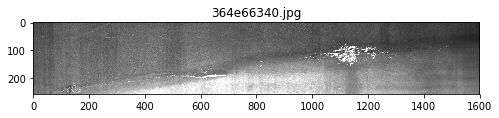

The images pixel resolution is (1600, 256)


In [38]:
# Sample Image
fig, ax = plt.subplots(1,1,figsize=(8, 7))
img = Image.open(str(TRAIN_PATH + X_train.ImageId.iloc[15]))
plt.imshow(img)
ax.set_title(X_train.ImageId.iloc[0])
plt.show()
print("The images pixel resolution is",img.size)

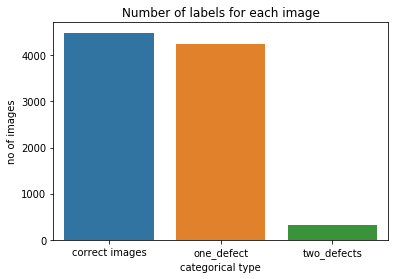

No. of Images with no defects: 4249, with only one defect: 4487, with two defects: 312


In [65]:
tmp = [sum(X_train['hasDefect_1']==1),
       sum(X_train['hasDefect_2']==1),
       sum(X_train['hasDefect_3']==1),
       sum(X_train['hasDefect_4']==1)]

tmp = (X_train['hasDefect_1']+X_train['hasDefect_2']+X_train['hasDefect_3']+X_train['hasDefect_4']).value_counts()
fig, ax = plt.subplots()
sns.barplot(x=['correct images','one_defect','two_defects'],y=tmp)
ax.set_title("Number of labels for each image")
ax.set_xlabel("categorical type")
ax.set_ylabel("no of images")
plt.show()
print("No. of Images with no defects: {}, with only one defect: {}, with two defects: {}".format(tmp[0],tmp[1],tmp[2]))

Conclusions:
Almost half of images doesn't contain any defects;

Most of images with defects contain the defects of only one type;

In rare cases an image contains the defects of two different types.

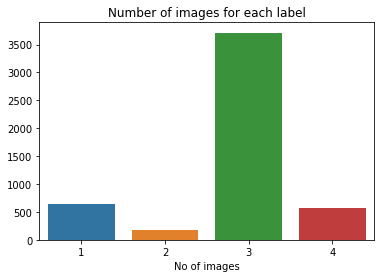

No. of Images having: Label 1 = 645, Label 2 = 178, Label 3 = 3712, Label 4 = 576 
 --------------------------------------------------


In [75]:
tmp = [sum(X_train['hasDefect_1']==1),
       sum(X_train['hasDefect_2']==1),
       sum(X_train['hasDefect_3']==1),
       sum(X_train['hasDefect_4']==1)]
fig, ax = plt.subplots()
sns.barplot(x=['1','2','3','4'],y=tmp)
ax.set_title("Number of images for each label")
ax.set_xlabel("Label")
ax.set_xlabel("No of images")
plt.show()
print("No. of Images having: Label 1 = {}, Label 2 = {}, Label 3 = {}, Label 4 = {}".format(tmp[0],tmp[1],tmp[2],tmp[3]),'\n','-'*50)


## Conclusions:

The dataset is very imbalanced.  

Data augmentation and resampling techniques will be required to perform the defect detection.

Sample images with no defects:


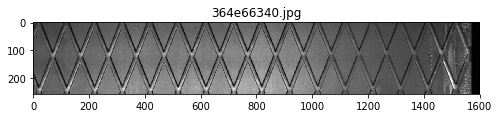

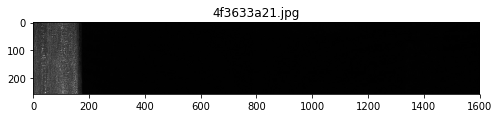

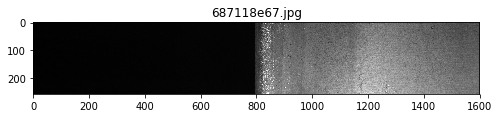

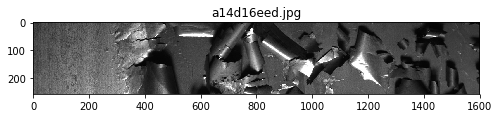

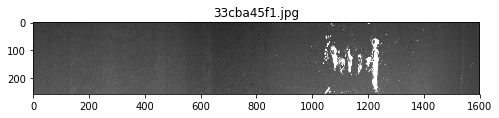

In [44]:
# 5 images having no defects
tmp = []
cnt=0
print("Sample images with no defects:")
for i in X_train['ImageId'][X_train['hasDefect']==0]:
    if cnt<5:
        fig, ax = plt.subplots(1,1,figsize=(8, 7))
        img = Image.open(str(TRAIN_PATH + i))
        plt.imshow(img)
        ax.set_title(i)
        plt.show()
        cnt+=1

#### Observation:
The surface of the non-defective steel may contain different features or profile. It has to be noted that that presence of defect is limited to the 4 types of defects in this dataset. The steel surface may contain other defects but those should not be detected.

In [45]:
# We need a function to convert EncodedPixels into mask
# https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode

#The surface of the non-defective steel may contain different features or profile.
#It has to be noted that that presence of defect is limited to the 4 types of defects in this dataset. 
#The steel surface may contain other defects but those should not be detected

def rle2mask(mask_rle, shape=(1600,256)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

Sample images with Class 1 defect:


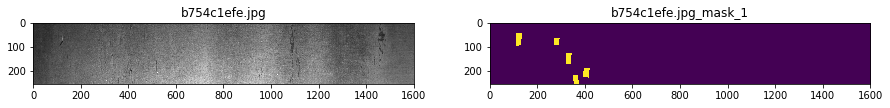

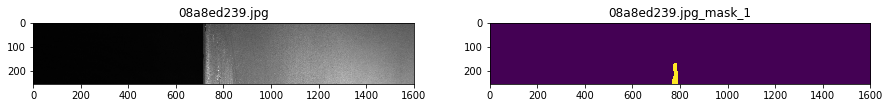

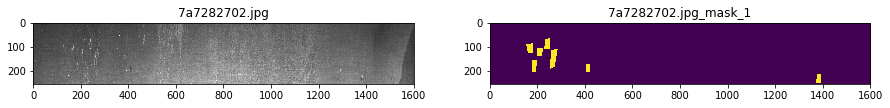

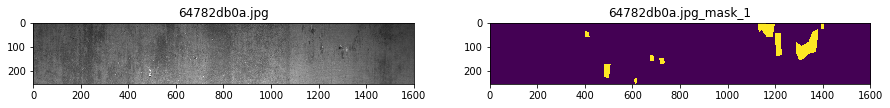

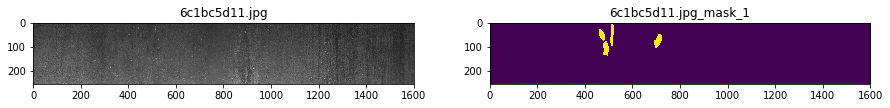

--------------------------------------------------------------------------------
Sample images with Class 2 defect:


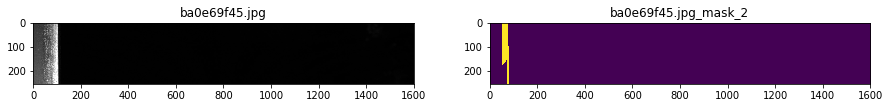

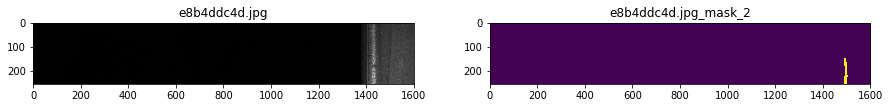

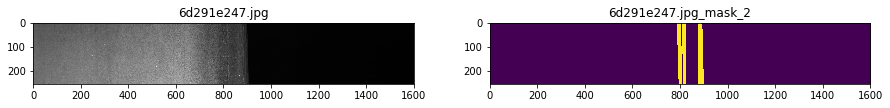

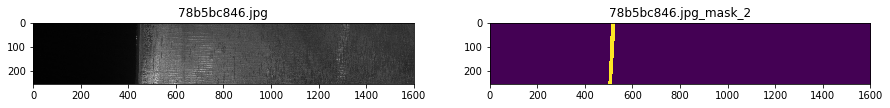

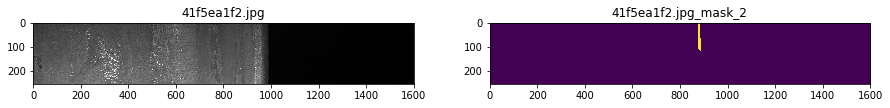

--------------------------------------------------------------------------------
Sample images with Class 3 defect:


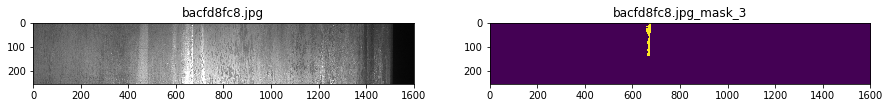

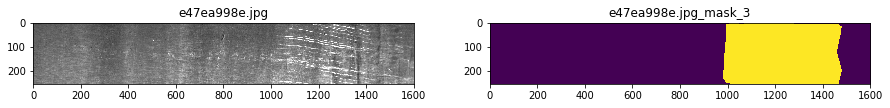

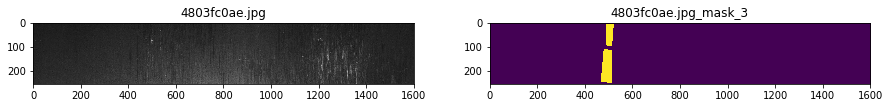

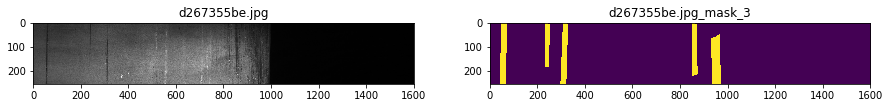

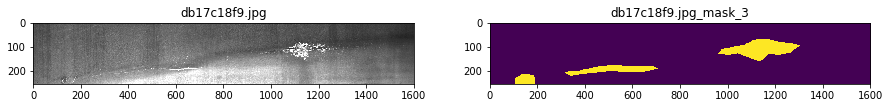

--------------------------------------------------------------------------------
Sample images with Class 4 defect:


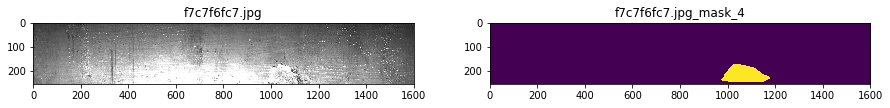

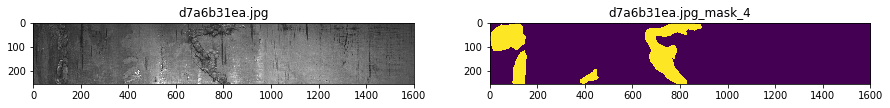

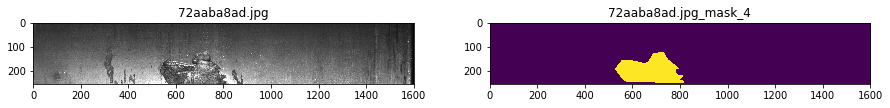

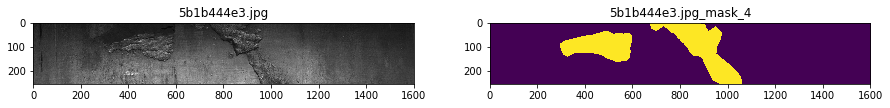

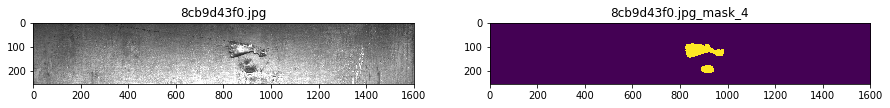

--------------------------------------------------------------------------------


In [47]:
# Visualization: Sample images having defect
for k in [1,2,3,4]:
    tmp = []
    cnt=0
    print("Sample images with Class {} defect:".format(k))
    for i in X_train[X_train[f'hasDefect_{k}']==1][['ImageId',f'Defect_{k}']].values:
        if cnt<5:
            fig, (ax1,ax2) = plt.subplots(nrows = 1,ncols = 2,figsize=(15, 7))
            img = Image.open(str(TRAIN_PATH + i[0]))
            ax1.imshow(img)
            ax1.set_title(i[0])
            cnt+=1
            ax2.imshow(rle2mask(i[1]))
            ax2.set_title(i[0]+'_mask_'+str(k))
            plt.show()
    print('-'*80)

#### Observation:
The regional profile on the masks of defect conataining steel surfaces can be seen to be indistinguishable among different classes. Though defect type 1 can be seen to have multiplte small size regions and defect type 4 images have multiple regions of medium size. Defect type 3 images can be seen to also contain multiple regions of medium size. While defect type 2 and type 3 images can be seen to share some regional characteristics.

'area' as a new feature  
Used for thresholding masks after generating predictions

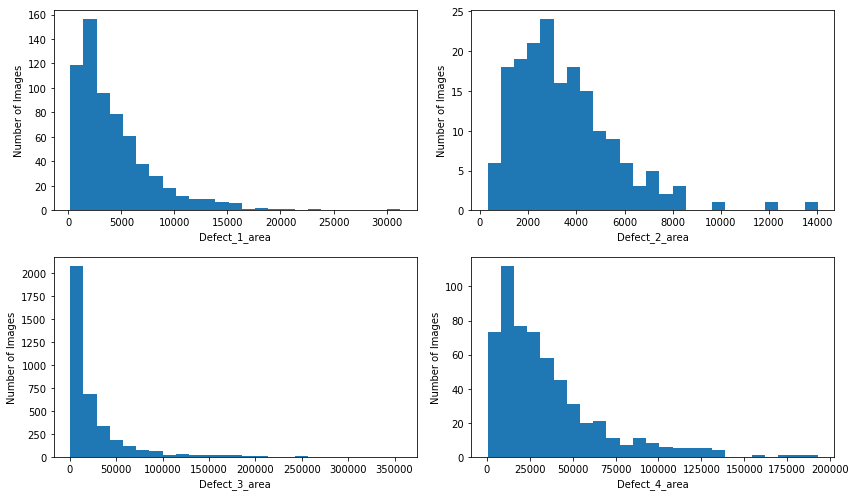

--------------------------------------------------


,count,mean,std,min,25%,50%,75%,max
Defect_1,645.0,4350.477519,3733.559124,163.0,1713.00,3243.0,5773.00,31303.0
Defect_2,178.0,3513.308989,2129.522333,316.0,2026.25,3086.0,4611.75,14023.0
Defect_3,3712.0,25593.268858,37296.152095,150.0,5044.50,12151.0,29399.00,356308.0
Defect_4,576.0,34795.451389,30578.036951,491.0,13248.00,25351.5,45025.25,192780.0


In [81]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2,figsize=(12,7))

tmp = X_train['Defect_1'][X_train['hasDefect_1']==1].apply(lambda s: sum([int(k) for k in s.split(' ')[1::2]]))
ax1.hist(tmp.values,bins = 25)
ax1.set_xlabel('Defect_1_area')
ax1.set_ylabel('Number of Images')


tmp = X_train['Defect_2'][X_train['hasDefect_2']==1].apply(lambda s: sum([int(k) for k in s.split(' ')[1::2]]))
ax2.hist(tmp.values,bins = 25)
ax2.set_xlabel('Defect_2_area')
ax2.set_ylabel('Number of Images')


tmp = X_train['Defect_3'][X_train['hasDefect_3']==1].apply(lambda s: sum([int(k) for k in s.split(' ')[1::2]]))
ax3.hist(tmp.values,bins = 25)
ax3.set_xlabel('Defect_3_area')
ax3.set_ylabel('Number of Images')


tmp = X_train['Defect_4'][X_train['hasDefect_4']==1].apply(lambda s: sum([int(k) for k in s.split(' ')[1::2]]))
ax4.hist(tmp.values,bins = 25)
ax4.set_xlabel('Defect_4_area')
ax4.set_ylabel('Number of Images')
plt.tight_layout()
plt.show()
print('-'*50)



tmp =[]
for i in [1,2,3,4]:

    tmp.append(X_train[f'Defect_{i}'][X_train[f'hasDefect_{i}']==1].apply(lambda s: sum([int(k) for k in s.split(' ')[1::2]])).describe())
area_df = pd.DataFrame(tmp)
area_df.index=['Defect_1','Defect_2','Defect_3','Defect_4']
area_df

There is considerable overlap in the range of area. Minimum area for each defect type can be seen closer to each other. While the maximum is largely different. We can use the minimum and maximum values of area in training images to threshold test image defect predictions

In [82]:
# removing areas below 2 percentile and above 98 percentile to threshold area of predicted masks
tmp = []
for i in [1,2,3,4]:
    tmp_1 = X_train[f'Defect_{i}'][X_train[f'hasDefect_{i}']==1].apply(lambda s: sum([int(k) for k in s.split(' ')[1::2]])).sort_values().reset_index().drop('index',axis=1)
    tmp.append([tmp_1.iloc[int(0.02*len(tmp_1))].values[0],tmp_1.iloc[-int(0.02*len(tmp_1))].values[0]])
print('Limiting area to above 2 percentile and below 98 percentile values: \n',tmp)

Limiting area to above 2 percentile and below 98 percentile values: 
 [[525, 15305], [751, 9641], [1146, 160085], [2882, 126754]]


In [83]:

area_threshold = pd.DataFrame([[500,15500],[700,10000],[1100,160000],[2800,127000]],
                               columns=['min','max'], index=['defect_1','defect_2','defect_3','defect_4'])
area_threshold # to threshold predictions

,min,max
defect_1,500,15500
defect_2,700,10000
defect_3,1100,160000
defect_4,2800,127000


#### EDA conclusion:
a) The dataset is imbalanced thus we will use stratified sampling for splitting the dataset into train and validation datasets.

b) This is a multi-label image segmentation problem. As there are around 50% of images with no defects, it is equally important to identify images with no defects.

c) Based on area thresholds from 'test_thresolds' dataframe and class probability thresholds (which are to be determined after predictions from neural networks), we will ensure that number of predicted images per defect will be closer to the values in 'count' column.

d) Procedure:

We will have a binary classification model to filter images with defects from no defect images.
A 4-label classification model to predict probablities of images beloning to each class.
4 segmentation models for four different classes to generate masks for each test image.
Convert masks to EncodedPixels and filter them as per classification probabilities.
e) We are generating a new solution to the business problem with available libraries: tensorflow, keras and segmentation_models.

Model architecture:


Blue dots in the Architecture image indicates that an input is being given at that level, while black dot near "Apply threholds" correspond to the application of thresholds at the output of predicted masks. At the threshold application level images are filtered based on Defect presence probability, Defect type belongingness and area of the defect.

### Data preparation and Model Building

In [84]:
train_segmentation = True
train_classification_binary = True
train_classification_multi = True
epochs = 30

In [85]:
# Metrics
# For image segmentation
# COMPETITION METRIC
# https://www.kaggle.com/xhlulu/severstal-simple-keras-u-net-boilerplate
def dice_coef(y_true, y_pred, smooth=K.epsilon()):
    '''
    This function returns dice coefficient of similarity between y_true and y_pred
    Dice coefficient is also referred to as F1_score, but we will use this name for image segmentation models
    For example, 
    let an instance on y_true and y_pred be [[1,1],[0,1]] and [[1,0],[0,1]]
    this metric first converts the above into [1,1,0,1] abd [1,0,0,1],
    then intersection is calculated as 1*1 + 1*0 + 0*1 + 1*1 = 2 and sum(y_true)+sum(y_pred)= 3+2 = 5
    this returns the value (2.* 2 + 10e-7)/(3 + 2 + 10e-7) ~ 0.8    
    '''
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Custom metrics, https://stackoverflow.com/questions/59196793/why-are-my-metrics-of-my-cnn-not-changing-with-each-epoch
# For clasification
def recall_m(y_true, y_pred):
    '''
    This function returns recall_score between y_true and y_pred
    This function is ported as a metric to the Neural Network Models
    Keras backend is used to take care of batch type training, the metric takes in a batch of y_pred and corresponding y_pred 
    as input and returns recall score of the batch
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) # calculates number of true positives
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))      # calculates number of actual positives
    recall = true_positives / (possible_positives + K.epsilon())   # K.epsilon takes care of non-zero divisions
    return recall

def precision_m(y_true, y_pred):
    '''
    This function returns precison_score between y_true and y_pred
    This function is ported as a metric to the Neural Network Models
    Keras backend is used to take care of batch type training, the metric takes in a batch of y_pred and corresponding y_pred 
    as input and returns prediction score of the batch
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))  # calculates number of true positives
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))      # calculates number of predicted positives   
    precision = true_positives /(predicted_positives + K.epsilon()) # K.epsilon takes care of non-zero divisions
    return precision
    
def f1_score_m(y_true, y_pred):
    '''
    This function returns f1_score between y_true and y_pred
    This 
    This function is ported as a metric to the Neural Network Models
    Keras backend is used to take care of batch type training, the metric takes in a batch of y_pred and corresponding y_pred 
    as input and returns f1 score of the batch
    '''
    precision = precision_m(y_true, y_pred)  # calls precision metric and takes the score of precision of the batch
    recall = recall_m(y_true, y_pred)        # calls recall metric and takes the score of precision of the batch
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

dependencies = {
    'recall_m':recall_m,
    'precision_m':precision_m,
    'dice_coef':dice_coef,
    'f1_score_m':f1_score_m,
    'dice_loss':sm.losses.dice_loss
}

### Binary Classification
Train and predict the probability of presence of defects in images.

In [86]:
X_train_binary = X_train[['ImageId','hasDefect']]
X_val_binary = X_val[['ImageId','hasDefect']]
X_test_binary = X_test[['ImageId','hasDefect']]

print(X_train.shape, X_val.shape, X_test.shape)
print(X_train_binary.shape, X_val_binary.shape, X_test_binary.shape)

(9048, 11) (2263, 11) (1257, 11)
(9048, 2) (2263, 2) (1257, 2)


In [87]:
# https://keras.io/preprocessing/image/
# https://stackoverflow.com/questions/52754492/write-custom-data-generator-for-keras

# DataGenerator for the binary classification model with image augmentations

train_DataGenerator_1 = ImageDataGenerator(rescale=1./255., shear_range=0.2, zoom_range=0.05, rotation_range=5,
                           width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True, vertical_flip=True)

test_DataGenerator_1 = ImageDataGenerator(rescale=1./255)

train_generator = train_DataGenerator_1.flow_from_dataframe(
        dataframe=X_train_binary.astype(str),
        directory=TRAIN_PATH,
        x_col="ImageId",
        y_col="hasDefect",
        target_size=(256,512),
        batch_size=16,
        class_mode='binary')

validation_generator = test_DataGenerator_1.flow_from_dataframe(
        dataframe=X_val_binary.astype(str),
        directory=TRAIN_PATH,
        x_col="ImageId",
        y_col="hasDefect",
        target_size=(256,512),
        batch_size=16,
        class_mode='binary')

Found 9048 validated image filenames belonging to 2 classes.
Found 2263 validated image filenames belonging to 2 classes.


In [88]:
base_model = tensorflow.keras.applications.xception.Xception(include_top = False, input_shape = (256,512,3))

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
 
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(64, activation='relu')(x)

# and the prediction layer
predictions = Dense(1, activation='sigmoid')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 512, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 127, 255, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 127, 255, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 127, 255, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [93]:
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['acc',f1_score_m,precision_m,recall_m])
model.fit_generator(train_generator, validation_data = validation_generator, epochs =2, verbose=1,)
 

Epoch 1/2
566/566 [==============================] - 27646s 49s/step - loss: 0.6358 - acc: 0.6657 - f1_score_m: 0.6911 - precision_m: 0.6753 - recall_m: 0.7559 - val_loss: 0.9008 - val_acc: 0.6089 - val_f1_score_m: 0.4781 - val_precision_m: 0.7491 - val_recall_m: 0.3758
Epoch 2/2
566/566 [==============================] - 28319s 50s/step - loss: 0.4218 - acc: 0.7992 - f1_score_m: 0.8058 - precision_m: 0.8192 - recall_m: 0.8234 - val_loss: 0.6156 - val_acc: 0.7879 - val_f1_score_m: 0.7879 - val_precision_m: 0.8181 - val_recall_m: 0.7866


In [108]:
test_DataGenerator_1


In [ ]:
#model.save()

In [ ]:
#.h5